# blocking identification 
### contrack - VAPV (some spatial pattern, why???)

In [38]:
from contrack import contrack
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm

In [39]:
#### FUNCTIONS #####
def print_now():
    print('time:'+str(datetime.datetime.now()))


In [80]:
### blocking method based on the original Code of Daniel Steinfeld 
xr_in=xr.open_mfdataset('/work/bm1235/b382006/regridding/icon/from_5km_to_1degree/vapv_weighted/VAPV_ngc2009_atm_pl_6h_inst_202*',concat_dim='time',combine='nested')

In [81]:
xr_in

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 3012)
Coordinates:
  * longitude  (longitude) float32 -179.9 -178.9 -177.9 ... 177.1 178.1 179.1
  * latitude   (latitude) float32 -89.95 -88.95 -87.95 ... 87.05 88.05 89.05
  * time       (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Data variables:
    VAPV       (time, latitude, longitude) float32 dask.array<chunksize=(4, 180, 360), meta=np.ndarray>
Attributes:
    title:    ICON nextGEMS simulation
    source:   giub@giub.unibe.ch
    comment:  to analyse weather systems

In [82]:
### intitate
block = contrack()
block.read_xarray(xr_in)

In [83]:
block.set_up(force=True)
block.ds = block.ds.compute() ### look at this!

            Hint: use set_up(force=True).
 1.000001   1.0000038 ]
            Hint: use set_up(force=True).
 1.000001   1.0000038 ]
            Hint: use set_up(force=True).
INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'



In [84]:
### compute anomalies
print_now()
print('computing vapv clim/anom')
block.calc_anom(variable='VAPV',
        smooth=8,
        window=31,
        groupby='dayofyear')


INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'

INFO: Calculating climatological mean from VAPV...


time:2023-02-07 18:04:34.264404
computing vapv clim/anom


INFO: Calculating Anomaly... DONE


In [85]:
####Identify and track blocks
block.run_contrack(variable='anom',
                   threshold=-1,
                   gorl='<=',
                   overlap=0.7,
                   persistence=20,
                   twosided=True)

INFO: 
Run ConTrack 
########### 
    threshold:    <= -1 
    overlap:      0.7 
    persistence:  20 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'

INFO: Find individual contours...
INFO: Apply overlap...
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
303 contours tracked


In [86]:
block

Xarray dataset with 3012 time steps. 
            Available fields: VAPV, anom, flag

In [87]:
# save to disk
#block['flag'].to_netcdf('/scratch/b/b382006/blocks_avapv_icon_5km.nc')

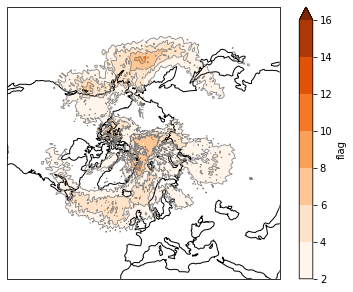

In [77]:
# plotting blocking frequency (in %) for winter over Northern Hemisphere
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
(xr.where(block['flag']>1,1,0).sum(dim='time')/block.ntime*100).plot(levels=np.arange(2,18,2), cmap='Oranges', extend = 'max', transform=ccrs.PlateCarree())
(xr.where(block['flag']>1,1,0).sum(dim='time')/block.ntime*100).plot.contour(colors='grey', linewidths=0.8, levels=np.arange(2,18,2), transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines();

In [78]:
# flag = output of block.run_contrack(), variable = input variable to calculate intensity and center of mass
block_df = block.run_lifecycle(flag='flag', variable='anom')
#block_df.to_csv('/scratch/b/b382006/blocks_avapv_icon_5km.table', index=False)



INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    anom
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'



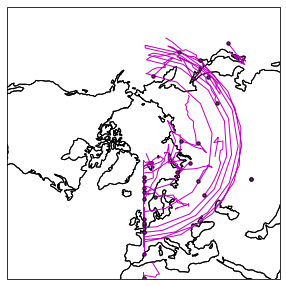

In [79]:
# plotting blocking track (center of mass) and genesis
f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines()
ax.coastlines() # add coastlines

#need to split each blocking track due to longitude wrapping (jumping at map edge)
for bid in np.unique(np.asarray(block_df['Flag'])): #select blocking id
    lons = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
    lats = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])

    # cosmetic: sometimes there is a gap near map edge where track is split:
    lons[lons >= 355] = 359.9
    lons[lons <= 3] = 0.1
    segment = np.vstack((lons,lats))

    #move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())
    #plot the starting points
    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())